Add all the imports and configure the python path

In [21]:

import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import pandas as pd
from radon.complexity import cc_visit
from radon.metrics import mi_visit

# Add the services directory to the Python path
services_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
if services_path not in sys.path:
    sys.path.append(services_path)

from services.agent_helpers import read_json_file
from services.result_evaluation import evaluate_codebleu_for_pairs, evaluate_time_logs
from services.output_validation import validate_python_syntax

In [22]:
# Specify and store all the file output and input directories.

OUTPUT_DIR = Path(os.getcwd()).parent / 'outputs'
GROUND_TRUTH = Path(os.getcwd()).parent / 'inputs' / 'ground_truth.json'
GROUND_TRUTH_TEST = Path(os.getcwd()).parent / 'inputs' / 'ground_truth_test.json'

SINGLE_AGENT_CODE_OUT = OUTPUT_DIR / 'single_agent_results'/ 'generated_python_code.json'
DOUBLE_AGENT_CODE_OUT = OUTPUT_DIR / 'double_agent_results'/ 'generated_python_code.json'

SINGLE_AGENT_TIME_OUT = OUTPUT_DIR / 'single_agent_results'/ 'time_log.json'
DOUBLE_AGENT_TIME_OUT = OUTPUT_DIR / 'double_agent_results'/ 'time_log.json'

MULTI_AGENT_TIME_OUT_AUTOMATED_TESTER = OUTPUT_DIR / 'multi_agent_results_automated_testcases'/ 'time_log.json'
MULTI_AGENT_CODE_OUT_AUTOMATED_TESTER = OUTPUT_DIR / 'multi_agent_results_automated_testcases'/ 'generated_python_code.json'
MULTI_AGENT_STATUS_OUT_AUTOMATED_TESTER = OUTPUT_DIR / 'multi_agent_results_automated_testcases'/ 'process_status.json'
MULTI_AGENT_TESTER_OUT_DIR_AUTOMATED_TESTER = OUTPUT_DIR / 'multi_agent_results_automated_testcases'/ 'generated_tests.json'

In [23]:
MULTI_AGENT_TIME_OUT_MANUAL_TESTER = OUTPUT_DIR / 'multi_agent_results_manual_testcases'/ 'time_log.json'
MULTI_AGENT_CODE_OUT_MANUAL_TESTER = OUTPUT_DIR / 'multi_agent_results_manual_testcases'/ 'generated_python_code.json'
MULTI_AGENT_STATUS_OUT_MANUAL_TESTER = OUTPUT_DIR / 'multi_agent_results_manual_testcases'/ 'process_status.json'
MULTI_AGENT_TESTER_OUT_DIR_MANUAL_TESTER = OUTPUT_DIR / 'multi_agent_results_manual_testcases'/ 'generated_tests.json'

MULTI_AGENT_TIMEOUT_MANUAL_TESTER_K_2 = OUTPUT_DIR / 'multi_agent_results_manual_k_2'/ 'time_log.json'
MULTI_AGENT_CODE_OUT_MANUAL_TESTER_K_2 = OUTPUT_DIR / 'multi_agent_results_manual_k_2'/ 'generated_python_code.json'
MULTI_AGENT_STATUS_OUT_MANUAL_TESTER_K_2 = OUTPUT_DIR / 'multi_agent_results_manual_k_2'/ 'process_status.json'
MULTI_AGENT_TESTER_OUT_DIR_MANUAL_TESTER_K_2 = OUTPUT_DIR / 'multi_agent_results_manual_k_2'/ 'generated_tests.json'

MULTI_AGENT_TIMEOUT_MANUAL_TESTER_K_1 = OUTPUT_DIR / 'multi_agent_results_manual_k_1'/ 'time_log.json'
MULTI_AGENT_CODE_OUT_MANUAL_TESTER_K_1 = OUTPUT_DIR / 'multi_agent_results_manual_k_1'/ 'generated_python_code.json'
MULTI_AGENT_STATUS_OUT_MANUAL_TESTER_K_1 = OUTPUT_DIR / 'multi_agent_results_manual_k_1'/ 'process_status.json'
MULTI_AGENT_TESTER_OUT_DIR_MANUAL_TESTER_K_1 = OUTPUT_DIR / 'multi_agent_results_manual_k_1'/ 'generated_tests.json'


In [24]:
#Agent ablation studies
MULTI_AGENT_CODE_WITHOUT_RE = OUTPUT_DIR / 'multi_agent_results_without_RE'/ 'generated_python_code.json'
MULTI_AGENT_TIME_OUT_WITHOUT_RE = OUTPUT_DIR / 'multi_agent_results_without_RE'/ 'time_log.json'
MULTI_AGENT_STATUS_OUT_WITHOUT_RE = OUTPUT_DIR / 'multi_agent_results_without_RE'/ 'process_status.json'
MULTI_AGENT_TESTER_OUT_DIR_WITHOUT_RE = OUTPUT_DIR / 'multi_agent_results_without_RE'/ 'generated_tests.json'

MULTIAGENT_CODE_WITHOUT_CRITIC = OUTPUT_DIR / 'multi_agent_results_without_Critic'/ 'generated_python_code.json'
MULTIAGENT_TIME_WITHOUT_CRITIC = OUTPUT_DIR / 'multi_agent_results_without_Critic'/ 'time_log.json'
MULTIAGENT_STATUS_WITHOUT_CRITIC = OUTPUT_DIR / 'multi_agent_results_without_Critic'/ 'process_status.json'
MULTIAGENT_TESTER_OUT_DIR_WITHOUT_CRITIC = OUTPUT_DIR / 'multi_agent_results_without_Critic'/ 'generated_tests.json'

Define a method to compute the ratio of the codes that are compilable (CSR Score)

In [25]:
# Fetch the ground truth and the translated code output files
ground_truth = read_json_file(str(GROUND_TRUTH))
ground_truth_test = read_json_file(str(GROUND_TRUTH_TEST))
# Single agent and double agent code fetch
single_agent_code = read_json_file(str(SINGLE_AGENT_CODE_OUT))
double_agent_code = read_json_file(str(DOUBLE_AGENT_CODE_OUT))

# Multi-agent code fetch for automated test case and manual test case k=3 scenario
multi_agent_automated_tester_code = read_json_file(str(MULTI_AGENT_CODE_OUT_AUTOMATED_TESTER))
multi_agent_manual_tester_code = read_json_file(str(MULTI_AGENT_CODE_OUT_MANUAL_TESTER))

# No. of iterations k =2
multi_agent_manual_tester_code_k_2 = read_json_file(str(MULTI_AGENT_CODE_OUT_MANUAL_TESTER_K_2))

# No. of iterations k =1
multi_agent_manual_tester_code_k_1 = read_json_file(str(MULTI_AGENT_CODE_OUT_MANUAL_TESTER_K_1))

# Compute time taken
single_agent_time = read_json_file(str(SINGLE_AGENT_TIME_OUT))
double_agent_time = read_json_file(str(DOUBLE_AGENT_TIME_OUT))
multi_agent_automated_tester_time = read_json_file(str(MULTI_AGENT_TIME_OUT_AUTOMATED_TESTER))
multi_agent_manual_tester_time = read_json_file(str(MULTI_AGENT_TIME_OUT_MANUAL_TESTER))
multi_agent_manual_tester_time_k_2 = read_json_file(str(MULTI_AGENT_TIMEOUT_MANUAL_TESTER_K_2))
multi_agent_manual_tester_time_k_1 = read_json_file(str(MULTI_AGENT_TIMEOUT_MANUAL_TESTER_K_1))

# Status file for multi_agent output
multi_agent_automated_tester_output_status = read_json_file(str(MULTI_AGENT_STATUS_OUT_AUTOMATED_TESTER))
multi_agent_manual_tester_output_status = read_json_file(str(MULTI_AGENT_STATUS_OUT_MANUAL_TESTER))
multi_agent_manual_tester_output_status_k_2 = read_json_file(str(MULTI_AGENT_STATUS_OUT_MANUAL_TESTER_K_2))
multi_agent_manual_tester_output_status_k_1 = read_json_file(str(MULTI_AGENT_STATUS_OUT_MANUAL_TESTER_K_1))


In [26]:
multi_agent_code_without_re = read_json_file(str(MULTI_AGENT_CODE_WITHOUT_RE))
multi_agent_time_without_re = read_json_file(str(MULTI_AGENT_TIME_OUT_WITHOUT_RE))
multi_agent_status_without_re = read_json_file(str(MULTI_AGENT_STATUS_OUT_WITHOUT_RE))
multi_agent_tester_out_dir_without_re = read_json_file(str(MULTI_AGENT_TESTER_OUT_DIR_WITHOUT_RE))

multi_agent_code_without_critic = read_json_file(str(MULTIAGENT_CODE_WITHOUT_CRITIC))
multi_agent_time_without_critic = read_json_file(str(MULTIAGENT_TIME_WITHOUT_CRITIC))
multi_agent_status_without_critic = read_json_file(str(MULTIAGENT_STATUS_WITHOUT_CRITIC))
multi_agent_tester_out_dir_without_critic = read_json_file(str(MULTIAGENT_TESTER_OUT_DIR_WITHOUT_CRITIC))

In [27]:
successful_keys = [
    key for key, value in list(multi_agent_automated_tester_output_status.items())
    if str(value).lower() == "success"
]

successful_outputs = {key: multi_agent_automated_tester_code[key] for key in successful_keys}
successful_output_times = {key: multi_agent_automated_tester_time[key] for key in successful_keys}

successful_keys_manual = {key: multi_agent_manual_tester_code[key] for key in successful_keys}
successful_output_times_manual = {key: multi_agent_manual_tester_time[key] for key in successful_keys}

# k=2
successful_keys_k_2 = {key: multi_agent_manual_tester_code_k_2[key] for key in successful_keys}

#k=1
successful_keys_k_1 = {key: multi_agent_manual_tester_code_k_1[key] for key in successful_keys}




Compute and print translation task time metric

In [73]:
avg_single_agent_time = evaluate_time_logs(single_agent_time)
avg_double_agent_time = evaluate_time_logs(double_agent_time)
avg_multi_agent_time_automated_tester = evaluate_time_logs(multi_agent_automated_tester_time)
avg_multi_agent_time_manual_tester = evaluate_time_logs(multi_agent_manual_tester_time)

#k=2
avg_multi_agent_time_manual_k_2 = evaluate_time_logs(multi_agent_manual_tester_time_k_2)
#k=1
avg_multi_agent_time_manual_k_1 = evaluate_time_logs(multi_agent_manual_tester_time_k_1)


AccessGatewayFilter: Time = 8.05361649999395
AreaCalculator: Time = 3.9686908000148833
ArgumentParser: Time = 8.61309280002024
ArrangementCalculator: Time = 7.571377100015525
AssessmentSystem: Time = 7.802765999978874
AutomaticGuitarSimulator: Time = 3.848669700033497
AvgPartition: Time = 2.4436550000100397
BalancedBrackets: Time = 4.0194388999952935
BankAccount: Time = 2.762500500015449
BigNumCalculator: Time = 12.802128899958916
BinaryDataProcessor: Time = 4.859619399998337
BitStatusUtil: Time = 3.2877047000220045
BlackjackGame: Time = 7.645672699960414
BookManagement: Time = 3.0925778000382707
BookManagementDB: Time = 9.066758800006937
BoyerMooreSearch: Time = 5.314400300034322
Calculator: Time = 8.608269800024573
CalendarUtil: Time = 9.250608800037298
CamelCaseMap: Time = 5.073425600014161
ChandrasekharSieve: Time = 3.3771611000411212
Chat: Time = 5.325412600010168
ClassRegistrationSystem: Time = 7.570210499980021
Classroom: Time = 9.645616900001187
CombinationCalculator: Time = 4.

In [74]:
def compute_time_stats(time_log):
    """Returns (mean, std) for a dict of time logs."""
    times = list(time_log.values())
    return float(np.mean(times)), float(np.std(times))

# Compute mean and std for each setup
avg_single_agent_time, std_single_agent_time = compute_time_stats(single_agent_time)
avg_double_agent_time, std_double_agent_time = compute_time_stats(double_agent_time)
avg_multi_agent_time_automated_tester, std_multi_agent_time_automated_tester = compute_time_stats(multi_agent_automated_tester_time)
avg_multi_agent_time_manual_tester, std_multi_agent_time_manual_tester = compute_time_stats(multi_agent_manual_tester_time)
    
#k=2
avg_multi_agent_time_manual_k_2, std_multi_agent_time_manual_k_2 = compute_time_stats(multi_agent_manual_tester_time_k_2)
#k=1
avg_multi_agent_time_manual_k_1, std_multi_agent_time_manual_k_1 = compute_time_stats(multi_agent_manual_tester_time_k_1)


Plot for Single, Double, Multi (Generated Test case)

In [ ]:
def plot_time_log_results_1(avg_single, avg_double, avg_multi, std_single, std_double, std_multi):
    """
    Plots the time log results for single, double, and multi agent evaluations,
    with standard deviation displayed next to the average.
    """
    plt.style.use('seaborn-v0_8-darkgrid')
    labels = ['Single Agent', 'Double Agent', 'Multi Agent (Generated Testcases)']
    scores = [avg_single, avg_double, avg_multi]
    stds = [std_single, std_double, std_multi]
    colors = ['#4F81BD', '#F28E2B', '#A5D86D']
    hatches = ['/', '\\', '|']

    fig, ax = plt.subplots(figsize=(7, 5))
    bars = ax.bar(labels, scores, color=colors, edgecolor='black', hatch=hatches, width=0.5, yerr=stds, capsize=8)

    ax.set_ylabel('Average Time (seconds)', fontsize=12)
    ax.set_title('Mean and Standard Deviation of Translation Times by Agent Configuration', fontsize=14, fontweight='bold')
    ax.set_ylim(0, max([a + s for a, s in zip(scores, stds)]) * 1.15)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels with std on top of bars
    for bar, avg, std in zip(bars, scores, stds):
        height = bar.get_height()
        ax.annotate(f'μ={avg:.2f}s\nσ={std:.2f}s',
                    xy=(bar.get_x(), height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

    # Add a text box to explain bars and error bars
    ax.text(0.02, 0.98, 'Bars: Mean Time (μ)\nLines: ±1 Standard Deviation (σ)', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top', 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.figtext(0.99, 0.01, 'Source: Multi-agent LLMs SE Research Thesis',
                horizontalalignment='right', fontsize=8, color='gray')
    plt.show()

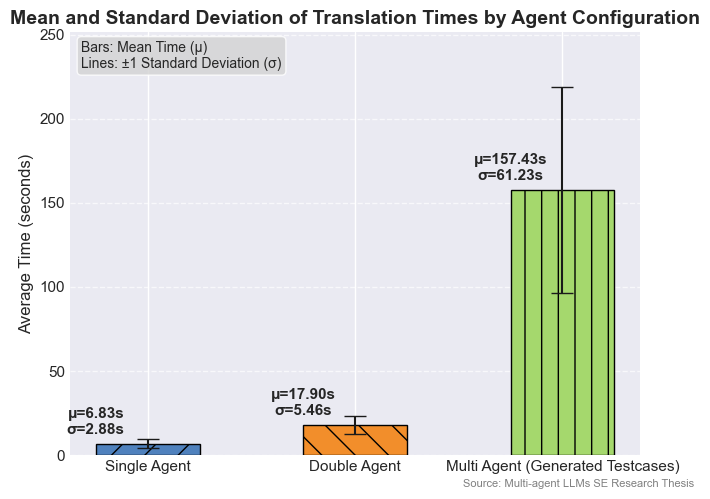

In [ ]:


# Call with std values
plot_time_log_results_1(
    avg_single_agent_time, avg_double_agent_time, avg_multi_agent_time_automated_tester,
    std_single_agent_time, std_double_agent_time, std_multi_agent_time_automated_tester
)

Plot for Multi (Generated Test case with Manual cases k= 3,2,1)

In [107]:
def plot_time_log_results_2(avg_automated, avg_manual_k_3, avg_manual_k_2, avg_manual_k_1,
                           std_automated, std_manual_k_3, std_manual_k_2, std_manual_k_1):
    """
    Plots the time log results for automated, manual (k =3,2,1) evaluations,
    with standard deviation displayed next to the average.
    """
    plt.style.use('seaborn-v0_8-darkgrid')
    labels = ['Generated Testcases', 'ClassEval-T Testcases (k=3)',
               'ClassEval-T Testcases (k=2)', 'ClassEval-T Testcases (k=1)']
    scores = [avg_automated, avg_manual_k_3, avg_manual_k_2, avg_manual_k_1]
    stds = [std_automated, std_manual_k_3, std_manual_k_2, std_manual_k_1]
    colors = ['#A5D86D', "#2BDEF2", "#D86DC6", '#E15759']
    hatches = ['/', '\\', '|', '-']  # Added '-' to match 4 labels
        
    fig, ax = plt.subplots(figsize=(7, 5))
    bars = ax.bar(labels, scores, color=colors, edgecolor='black', hatch=hatches, width=0.5, yerr=stds, capsize=8)

    ax.set_ylabel('Average Time (seconds)', fontsize=10)
    ax.set_title('Mean and Standard Deviation of Translation Times by Agent Configuration', fontsize=8, fontweight='bold')
    ax.set_ylim(0, max([a + s for a, s in zip(scores, stds)]) * 1.15)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Set x-tick labels with reduced font size
    ax.set_xticklabels(labels, fontsize=8)

    # Add value labels with std on top of bars
    for bar, avg, std in zip(bars, scores, stds):
        height = bar.get_height()
        ax.annotate(f'μ={avg:.2f}s\nσ={std:.2f}s',
                    xy=(bar.get_x(), height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Add a text box to explain bars and error bars
    ax.text(0.02, 0.98, 'Bars: Mean Time (μ)\nLines: ±1 Standard Deviation (σ)', 
            transform=ax.transAxes, fontsize=8, verticalalignment='top', 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.8))
    
    # Add a text box to explain the experiment
    ax.text(0.6, 0.98, 'Multi-agent experiment setups', 
            transform=ax.transAxes, fontsize=8, verticalalignment='top', 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.figtext(0.99, 0.01, 'Source: Multi-agent LLMs SE Research Thesis',
                horizontalalignment='right', fontsize=6, color='gray')
    plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_31296\893848820.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, fontsize=8)


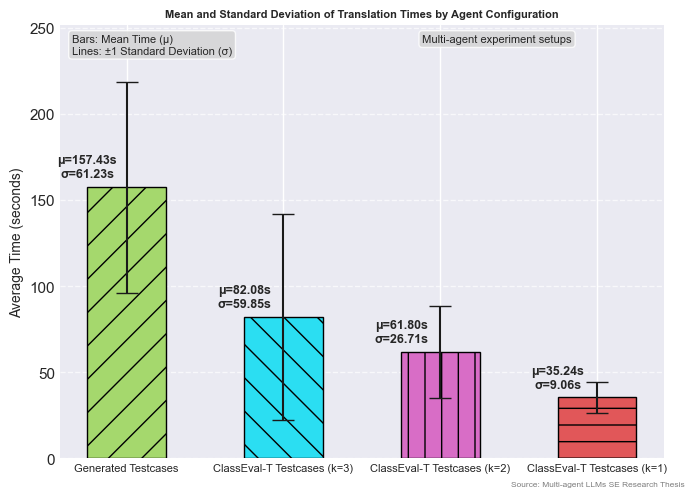

In [108]:
# Call with std values
plot_time_log_results_2(
    avg_multi_agent_time_automated_tester, avg_multi_agent_time_manual_tester,
      avg_multi_agent_time_manual_k_2, avg_multi_agent_time_manual_k_1,
    std_multi_agent_time_automated_tester, std_multi_agent_time_manual_tester,
    std_multi_agent_time_manual_k_2, std_multi_agent_time_manual_k_1
)

Compute CodeBleu and plot the results

In [109]:
    # Evaluate CodeBLEU scores
single_results = evaluate_codebleu_for_pairs(ground_truth, single_agent_code)
double_results = evaluate_codebleu_for_pairs(ground_truth, double_agent_code)
multi_results_automated_testcases = evaluate_codebleu_for_pairs(ground_truth, successful_outputs)
multi_results_manual_testcases = evaluate_codebleu_for_pairs(ground_truth, successful_keys_manual)


#
manual_k_2 = evaluate_codebleu_for_pairs(ground_truth, successful_keys_k_2)
manual_k_1 = evaluate_codebleu_for_pairs(ground_truth, successful_keys_k_1)

In [110]:
def codebleu_stats(results_dict):
    """Compute std, min, max for a dict of codebleu scores."""
    scores = [v['codebleu'] if isinstance(v, dict) and 'codebleu' in v else v for v in results_dict.values()]
    scores = [s for s in scores if s is not None]
    if not scores:
        return {'std': None, 'min': None, 'max': None}
    return {
        'std': float(np.std(scores)),
        'min': float(np.min(scores)),
        'max': float(np.max(scores)),
        'avg': float(np.mean(scores))
    }

single_stats = codebleu_stats(single_results)
double_stats = codebleu_stats(double_results)
multi_stats_automated = codebleu_stats(multi_results_automated_testcases)
multi_stats_manual = codebleu_stats(multi_results_manual_testcases)
multi_stats_k_2 = codebleu_stats(manual_k_2)
multi_stats_k_1 = codebleu_stats(manual_k_1)

print("Single Agent CodeBLEU: std={:.4f}, avg={:.4f}, min={:.4f}, max={:.4f}".format(
    single_stats['std'], single_stats['avg'], single_stats['min'], single_stats['max']))
print("Double Agent CodeBLEU: std={:.4f}, avg={:.4f}, min={:.4f}, max={:.4f}".format(
    double_stats['std'], double_stats['avg'], double_stats['min'], double_stats['max']))
print("Multi Agent CodeBLEU (Automated): std={:.4f}, avg={:.4f}, min={:.4f}, max={:.4f}".format(
    multi_stats_automated['std'], multi_stats_automated['avg'], multi_stats_automated['min'], multi_stats_automated['max']))
print("Multi Agent CodeBLEU (Manual): std={:.4f}, avg={:.4f}, min={:.4f}, max={:.4f}".format(
    multi_stats_manual['std'], multi_stats_manual['avg'], multi_stats_manual['min'], multi_stats_manual['max']))


print("Multi Agent CodeBLEU (Manual  K=2): std={:.4f}, avg={:.4f}, min={:.4f}, max={:.4f}".format(
    multi_stats_k_2['std'], multi_stats_k_2['avg'], multi_stats_k_2['min'], multi_stats_k_2['max']))
print("Multi Agent CodeBLEU (Manual K=1): std={:.4f}, avg={:.4f}, min={:.4f}, max={:.4f}".format(
    multi_stats_k_1['std'], multi_stats_k_1['avg'], multi_stats_k_1['min'], multi_stats_k_1['max']))



Single Agent CodeBLEU: std=0.1790, avg=0.5433, min=0.1067, max=1.0000
Double Agent CodeBLEU: std=0.1682, avg=0.5397, min=0.1131, max=1.0000
Multi Agent CodeBLEU (Automated): std=0.1449, avg=0.4923, min=0.1184, max=0.9569
Multi Agent CodeBLEU (Manual): std=0.1543, avg=0.5293, min=0.1967, max=1.0000
Multi Agent CodeBLEU (Manual  K=2): std=0.1528, avg=0.5158, min=0.1429, max=0.9569
Multi Agent CodeBLEU (Manual K=1): std=0.1591, avg=0.5222, min=0.1148, max=1.0000


In [111]:
def get_min_max_keys(results_dict):
    """Return the keys (program names) with min and max codebleu scores."""
    scores = {k: (v['codebleu'] if isinstance(v, dict) and 'codebleu' in v else v) for k, v in results_dict.items()}
    scores = {k: s for k, s in scores.items() if s is not None}
    if not scores:
        return None, None
    min_key = min(scores, key=scores.get)
    max_key = max(scores, key=scores.get)
    return min_key, max_key

# For each setup
single_min_key, single_max_key = get_min_max_keys(single_results)
double_min_key, double_max_key = get_min_max_keys(double_results)
multi_min_key_automated, multi_max_key_automated = get_min_max_keys(multi_results_automated_testcases)
multi_min_key_manual, multi_max_key_manual = get_min_max_keys(multi_results_manual_testcases)

print(f"Single Agent: min={single_min_key}, max={single_max_key}")
print(f"Double Agent: min={double_min_key}, max={double_max_key}")
print(f"Multi Agent (Automated): min={multi_min_key_automated}, max={multi_max_key_automated}")
print(f"Multi Agent (Manual): min={multi_min_key_manual}, max={multi_max_key_manual}")

Single Agent: min=URLHandler, max=BankAccount
Double Agent: min=URLHandler, max=BankAccount
Multi Agent (Automated): min=URLHandler, max=GomokuGame
Multi Agent (Manual): min=URLHandler, max=BankAccount


Print Compilation success rate (CSR Score)

In [112]:
def compute_compile_ratio(output_codes):
    """
    Computes the compilation ratio for the translated code.
    """
    success_count = 0
    count = 0

    for key, translated_code in output_codes.items():
        result = validate_python_syntax(translated_code)
        if result.get("valid", True):
            success_count += 1
        count += 1

    return success_count / count if count > 0 else 0

In [113]:
    # Compute compilation ratios
single_agent_compile_ratio = compute_compile_ratio(single_agent_code)
double_agent_compile_ratio = compute_compile_ratio(double_agent_code)
multi_agent_compile_ratio_automated = compute_compile_ratio(successful_outputs)
multi_agent_compile_ratio_manual = compute_compile_ratio(successful_keys_manual)

print(f"Single Agent Compilation Ratio: {single_agent_compile_ratio:.2%}")
print(f"Double Agent Compilation Ratio: {double_agent_compile_ratio:.2%}")
print(f"Multi Agent Compilation Ratio (Automated): {multi_agent_compile_ratio_automated:.2%}")
print(f"Multi Agent Compilation Ratio (Manual): {multi_agent_compile_ratio_manual:.2%}")


 [PYTHON SYNTAX VALIDATION] Validating Python syntax...
 Code length: 1708 characters
 Python syntax is valid!

 [PYTHON SYNTAX VALIDATION] Validating Python syntax...
 Code length: 930 characters
 Python syntax is valid!

 [PYTHON SYNTAX VALIDATION] Validating Python syntax...
 Code length: 1980 characters
 Python syntax is valid!

 [PYTHON SYNTAX VALIDATION] Validating Python syntax...
 Code length: 1652 characters
 Python syntax is valid!

 [PYTHON SYNTAX VALIDATION] Validating Python syntax...
 Code length: 1811 characters
 Python syntax is valid!

 [PYTHON SYNTAX VALIDATION] Validating Python syntax...
 Code length: 859 characters
 Python syntax is valid!

 [PYTHON SYNTAX VALIDATION] Validating Python syntax...
 Code length: 490 characters
 Python syntax is valid!

 [PYTHON SYNTAX VALIDATION] Validating Python syntax...
 Code length: 878 characters
 Python syntax is valid!

 [PYTHON SYNTAX VALIDATION] Validating Python syntax...
 Code length: 669 characters
 Python syntax is vali

Print average number of passed/ failed test cases of tester agent for successful and errored translation.

In [34]:

tester_outputs = read_json_file(str(MULTI_AGENT_TESTER_OUT_DIR_AUTOMATED_TESTER))  # fetch all outputs of the tester agent for all programs.

# Ensure tester_outputs is a dict
if not isinstance(tester_outputs, dict):
    print(f"Warning: tester_outputs is not a dict (type={type(tester_outputs)}). Treating as empty dict.")
    tester_outputs = {}

# Filter to select only those outputs from successful program runs,
# but only include keys that actually exist in tester_outputs
successful_tester_outputs = {}
missing_keys = []
for key in successful_keys:
    if key in tester_outputs:
        successful_tester_outputs[key] = tester_outputs[key]
    else:
        missing_keys.append(key)

if missing_keys:
    print(f"key not found in tester_outputs: {len(missing_keys)} {missing_keys[:10]}{'...' if len(missing_keys)>10 else ''}")

import re
# Regex to capture the content of the fenced ```test_results block
pattern = r"```test_results(?:\r?\n)([\s\S]*?)```"

last_test_results = {}

for key, output in successful_tester_outputs.items():
    matches = re.findall(pattern, str(output))
    if matches:
        last_test_results[key] = matches[-1].strip()  # take last occurrence and trim whitespace

# Now last_test_results contains the mapping
print(last_test_results)


key not found in tester_outputs: 1 ['NumericEntityUnescaper']
{'AccessGatewayFilter': 'Test Summary:\n-TOTAL NUMBER OF TESTS EXECUTED: 8\n-C++: 8 passed, 0 failed\n-Python: 8 passed, 0 failed\n-ANY DIFFERENCES IN TEST OUTCOMES BETWEEN THE TWO IMPLEMENTATIONS: None; all test outcomes matched.', 'AreaCalculator': "Test Summary:\n-TOTAL NUMBER OF TESTS EXECUTED: 0\n-C++: 0 passed, 0 failed\n-Python: 0 passed, 0 failed\n-Any differences in outcomes between the two implementations: none observed (no tests executed)\nNote: The test runner returned zero executed tests. The test method sets for both C++ and Python were provided above and are consistent (test names match). If you want me to re-run the tests or adapt the tests to a different runner format, tell me which test runner/environment to target (e.g., gtest main for C++, pytest or unittest for Python) and I'll adjust.", 'ArgumentParser': 'Test Summary:\n-TOTAL NUMBER OF TESTS EXECUTED: 10\n-C++: 10 passed, 0 failed\n-Python: 10 passed, 

Compute The code complexity of the translated codes to measure their qualitative differences.

In [33]:
def measure_code_complexity(code_dict):
    """
    Measures cyclomatic complexity and maintainability index for each code snippet in the dict.
    Returns a dict with keys as input keys and values as {'cc': avg cyclomatic complexity, 'mi': maintainability index}.
    """
    results = {}
    for key, code in code_dict.items():
        try:
            cc_scores = cc_visit(code)
            avg_cc = sum([c.complexity for c in cc_scores]) / len(cc_scores) if cc_scores else 0
            mi = mi_visit(code, True)
            results[key] = {'cc': avg_cc, 'mi': mi}
        except Exception as e:
            results[key] = {'cc': None, 'mi': None, 'error': str(e)}
    return results

complexity_single = measure_code_complexity(single_agent_code)
complexity_double = measure_code_complexity(double_agent_code)
complexity_multi  = measure_code_complexity(multi_agent_automated_tester_code)
complexity_multi_manual  = measure_code_complexity(multi_agent_manual_tester_code)


complexity_multi_manual_k_2 = measure_code_complexity(multi_agent_manual_tester_code_k_2)
complexity_multi_manual_k_1 = measure_code_complexity(multi_agent_manual_tester_code_k_1)

complexity_multi_without_re = measure_code_complexity(multi_agent_code_without_re)
complexity_multi_without_critic = measure_code_complexity(multi_agent_code_without_critic)


In [34]:
def compute_code_qualitative_stats(code_quality_results):
    """
    Computes the average, std, min, max, median, and quartile ranges for cyclomatic complexity and maintainability index.
    Also computes the percentage of programs with cc > 10.
    """
    import numpy as np

    cc_values = [result['cc'] for result in code_quality_results.values() if result['cc'] is not None]
    mi_values = [result['mi'] for result in code_quality_results.values() if result['mi'] is not None]
    count = len(cc_values)

    def stats(arr):
        if not arr:
            return dict(avg=None, std=None, min=None, max=None, median=None, q1=None, q3=None)
        arr_np = np.array(arr)
        return dict(
            avg=float(np.mean(arr_np)),
            std=float(np.std(arr_np)),
            min=float(np.min(arr_np)),
            max=float(np.max(arr_np)),
            median=float(np.median(arr_np)),
            q1=float(np.percentile(arr_np, 25)),
            q3=float(np.percentile(arr_np, 75)),
        )

    cc_stats = stats(cc_values)
    mi_stats = stats(mi_values)
    count_above_10 = sum(1 for cc in cc_values if cc > 10)
    pct_above_10 = (count_above_10 / count * 100) if count else 0.0

    return {
        'cc': cc_stats,
        'mi': mi_stats,
        'count': count,
        'count_cc_above_10': count_above_10,
        'pct_cc_above_10': pct_above_10,
    }

average_complexity_single = compute_code_qualitative_stats(complexity_single)
average_complexity_double = compute_code_qualitative_stats(complexity_double)
average_complexity_multi = compute_code_qualitative_stats(complexity_multi)
average_complexity_multi_manual = compute_code_qualitative_stats(complexity_multi_manual)

average_complexity_multi_manual_k_2 = compute_code_qualitative_stats(complexity_multi_manual_k_2)
average_complexity_multi_manual_k_1 = compute_code_qualitative_stats(complexity_multi_manual_k_1)

average_complexity_multi_without_re = compute_code_qualitative_stats(complexity_multi_without_re)
average_complexity_multi_without_critic = compute_code_qualitative_stats(complexity_multi_without_critic)


In [37]:
average_complexity_single

{'cc': {'avg': 2.8244011898267214,
  'std': 1.277743705529167,
  'min': 1.1111111111111112,
  'max': 6.5,
  'median': 2.3333333333333335,
  'q1': 2.0,
  'q3': 3.5},
 'mi': {'avg': 52.4637792907421,
  'std': 14.321520928597018,
  'min': 30.05067933780816,
  'max': 100.0,
  'median': 48.816925746657894,
  'q1': 44.61698345180583,
  'q3': 55.73886008089779},
 'count': 94,
 'count_cc_above_10': 0,
 'pct_cc_above_10': 0.0}

In [38]:
average_complexity_double

{'cc': {'avg': 2.895392616700501,
  'std': 1.303441423506263,
  'min': 1.1111111111111112,
  'max': 6.5,
  'median': 2.4222222222222225,
  'q1': 2.1145833333333335,
  'q3': 3.475},
 'mi': {'avg': 52.7719770933227,
  'std': 14.415593911153227,
  'min': 32.05071791514268,
  'max': 100.0,
  'median': 48.92012041079173,
  'q1': 44.627077721730835,
  'q3': 56.509805151741304},
 'count': 94,
 'count_cc_above_10': 0,
 'pct_cc_above_10': 0.0}

In [39]:
average_complexity_multi

{'cc': {'avg': 2.9416170413510843,
  'std': 1.3917632310234906,
  'min': 1.1111111111111112,
  'max': 9.333333333333334,
  'median': 2.4772727272727275,
  'q1': 2.013888888888889,
  'q3': 3.5},
 'mi': {'avg': 60.40493522780344,
  'std': 17.524844793783334,
  'min': 30.267590414275244,
  'max': 100.0,
  'median': 57.99377373475927,
  'q1': 45.42543015704655,
  'q3': 73.77195125830208},
 'count': 94,
 'count_cc_above_10': 0,
 'pct_cc_above_10': 0.0}

In [40]:
average_complexity_multi_manual

{'cc': {'avg': 3.074318825382656,
  'std': 1.5608658679274248,
  'min': 1.1111111111111112,
  'max': 12.0,
  'median': 2.5773809523809526,
  'q1': 2.125,
  'q3': 3.561904761904762},
 'mi': {'avg': 57.09480973010495,
  'std': 15.954774356619703,
  'min': 30.60431927109196,
  'max': 100.0,
  'median': 53.2955989607539,
  'q1': 46.0081289160976,
  'q3': 64.86117118464618},
 'count': 94,
 'count_cc_above_10': 1,
 'pct_cc_above_10': 1.0638297872340425}

In [41]:
average_complexity_multi_manual_k_2

{'cc': {'avg': 2.9883399091265836,
  'std': 1.517710032329977,
  'min': 1.1111111111111112,
  'max': 12.0,
  'median': 2.5357142857142856,
  'q1': 2.125,
  'q3': 3.475},
 'mi': {'avg': 56.251889674104824,
  'std': 15.628863608711079,
  'min': 37.060204625104774,
  'max': 100.0,
  'median': 51.621468294839914,
  'q1': 44.905384387583595,
  'q3': 63.67053264403106},
 'count': 94,
 'count_cc_above_10': 1,
 'pct_cc_above_10': 1.0638297872340425}

In [42]:
average_complexity_multi_manual_k_1

{'cc': {'avg': 2.887530200296158,
  'std': 1.2509396885273856,
  'min': 1.1111111111111112,
  'max': 6.5,
  'median': 2.5,
  'q1': 2.0,
  'q3': 3.5},
 'mi': {'avg': 55.168929052278365,
  'std': 15.521437508569846,
  'min': 31.29118329850839,
  'max': 100.0,
  'median': 51.64871916033677,
  'q1': 44.78666696486178,
  'q3': 58.900089130118936},
 'count': 94,
 'count_cc_above_10': 0,
 'pct_cc_above_10': 0.0}

In [35]:
average_complexity_multi_without_re

{'cc': {'avg': 2.870870057838143,
  'std': 1.261372395594845,
  'min': 1.1111111111111112,
  'max': 6.5,
  'median': 2.414285714285714,
  'q1': 2.0,
  'q3': 3.5},
 'mi': {'avg': 53.35028757809595,
  'std': 14.244353041894794,
  'min': 30.15836208565367,
  'max': 100.0,
  'median': 49.36771499405498,
  'q1': 44.74072027986876,
  'q3': 57.99885686009911},
 'count': 94,
 'count_cc_above_10': 0,
 'pct_cc_above_10': 0.0}

In [12]:
average_complexity_multi_without_critic

{'cc': {'avg': 2.870616765031659,
  'std': 1.2672779464083892,
  'min': 1.1111111111111112,
  'max': 6.5,
  'median': 2.4,
  'q1': 2.0,
  'q3': 3.5},
 'mi': {'avg': 53.43651250280128,
  'std': 14.231097401588897,
  'min': 30.15836208565367,
  'max': 100.0,
  'median': 49.58145218759367,
  'q1': 44.78206423527638,
  'q3': 57.99885686009911},
 'count': 94,
 'count_cc_above_10': 0,
 'pct_cc_above_10': 0.0}

Printing the cc and mi scores of each prg as a scatter plot

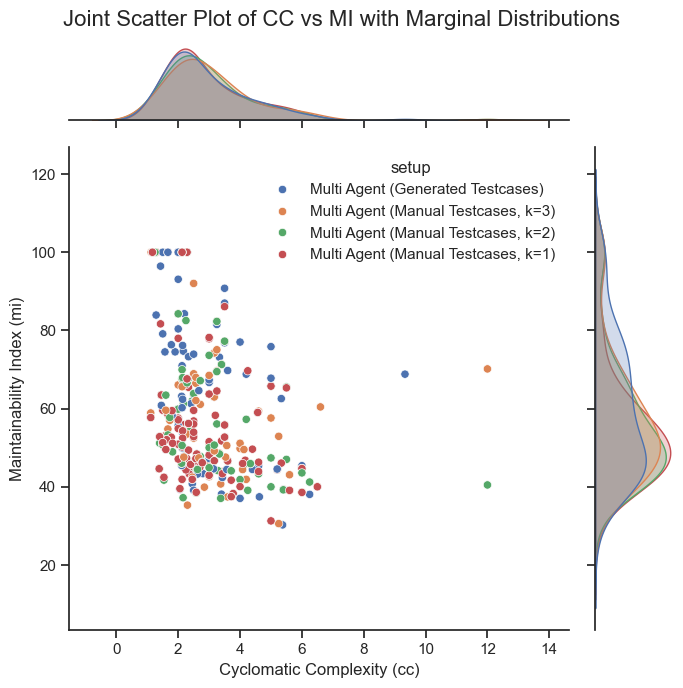

In [124]:
# Prepare a DataFrame for seaborn
all_keys = list(complexity_multi.keys()) # get all the keys

cc_multi = [complexity_multi[k]['cc'] for k in all_keys]
mi_multi = [complexity_multi[k]['mi'] for k in all_keys]

cc_multi_manual = [complexity_multi_manual[k]['cc'] for k in all_keys]
mi_multi_manual = [complexity_multi_manual[k]['mi'] for k in all_keys]

cc_multi_manual_k_2 = [complexity_multi_manual_k_2[k]['cc'] for k in all_keys]
mi_multi_manual_k_2 = [complexity_multi_manual_k_2[k]['mi'] for k in all_keys]

cc_multi_manual_k_1 = [complexity_multi_manual_k_1[k]['cc'] for k in all_keys]
mi_multi_manual_k_1 = [complexity_multi_manual_k_1[k]['mi'] for k in all_keys]

data = []
for i, key in enumerate(all_keys):
    data.append({'cc': cc_multi[i], 'mi': mi_multi[i], 'setup': 'Multi Agent (Generated Testcases)'})
    data.append({'cc': cc_multi_manual[i], 'mi': mi_multi_manual[i], 'setup': 'Multi Agent (Manual Testcases, k=3)'})
    data.append({'cc': cc_multi_manual_k_2[i],  'mi': mi_multi_manual_k_2[i],  'setup': 'Multi Agent (Manual Testcases, k=2)'})
    data.append({'cc': cc_multi_manual_k_1[i],  'mi': mi_multi_manual_k_1[i],  'setup': 'Multi Agent (Manual Testcases, k=1)'})
df = pd.DataFrame(data)

# Set seaborn style
sns.set_theme(style="ticks")

g = sns.jointplot(
    data=df,
    x="cc",
    y="mi",
    hue="setup",
    kind="scatter", 
    height=7,
    space=0.2
)

g.set_axis_labels("Cyclomatic Complexity (cc)", "Maintainability Index (mi)")
g.figure.suptitle("Joint Scatter Plot of CC vs MI with Marginal Distributions", fontsize=16)
g.figure.tight_layout()
g.figure.subplots_adjust(top=0.93)

List the top, and lowest 3 programs cc, mi scores in a table

In [118]:
def get_top_bottom_keys(complexity_dict, metric='cc', top_n=3):
    filtered = [(k, v[metric]) for k, v in complexity_dict.items() if v[metric] is not None]
    sorted_items = sorted(filtered, key=lambda x: x[1])
    # Get lowest and highest
    bottom = sorted_items[:top_n]
    top = sorted_items[-top_n:][::-1]
    return top, bottom

for setup_name, complexity_dict in [
    #("Single Agent", complexity_single),
    #("Double Agent", complexity_double),
    ("Multi Agent (Generated Testcases)", complexity_multi),
    ("Multi Agent (Manual Testcases)", complexity_multi_manual),
    ("Multi Agent (Manual Testcases, k=2)", complexity_multi_manual_k_2),
    ("Multi Agent (Manual Testcases, k=1)", complexity_multi_manual_k_1)
]:
    print(f"\n{setup_name}:")
    for metric in ['cc', 'mi']:
        top, bottom = get_top_bottom_keys(complexity_dict, metric)
        print(f"  Top 3 {metric.upper()} programs:")
        for k, v in top:
            print(f"    {k}: {v:.2f}")
        print(f"  Lowest 3 {metric.upper()} programs:")
        for k, v in bottom:
            print(f"    {k}: {v:.2f}")


Multi Agent (Generated Testcases):
  Top 3 CC programs:
    Interpolation: 9.33
    Words2Numbers: 6.50
    BigNumCalculator: 6.25
  Lowest 3 CC programs:
    TimeUtils: 1.11
    NumberConverter: 1.29
    RPGCharacter: 1.38
  Top 3 MI programs:
    TextFileProcessor: 100.00
    StudentDatabaseProcessor: 100.00
    MovieTicketDB: 100.00
  Lowest 3 MI programs:
    ExpressionCalculator: 30.27
    NumberWordFormatter: 37.05
    Statistics3: 37.45

Multi Agent (Manual Testcases):
  Top 3 CC programs:
    Interpolation: 12.00
    SQLQueryBuilder: 6.60
    Words2Numbers: 6.50
  Lowest 3 CC programs:
    TimeUtils: 1.11
    StudentDatabaseProcessor: 1.12
    TextFileProcessor: 1.17
  Top 3 MI programs:
    TextFileProcessor: 100.00
    StudentDatabaseProcessor: 100.00
    NumberConverter: 100.00
  Lowest 3 MI programs:
    ExpressionCalculator: 30.60
    StockPortfolioTracker: 35.32
    EightPuzzle: 37.43

Multi Agent (Manual Testcases, k=2):
  Top 3 CC programs:
    Interpolation: 12.00
   

Extracting Cpp and python tests generated by the tester agent

In [125]:
INP_PRG_DIR = Path(os.getcwd()).parent / 'inputs' / 'input_program.json'
input_program = read_json_file(str(INP_PRG_DIR))

In [ ]:
# Extract C++ and Python test code blocks from tester_outputs and store in variables
cpp_tests_blocks = {}
py_tests_blocks = {}

# Patterns to match fenced code blocks: ```cpp_tests ... ``` and ```py_tests ... ```
cpp_tests_pattern = re.compile(r"```cpp_tests(?:\r?\n)([\s\S]*?)```", re.IGNORECASE)
py_tests_pattern = re.compile(r"```py_tests(?:\r?\n)([\s\S]*?)```", re.IGNORECASE)

for key, output in tester_outputs.items():
    output_str = str(output)
    cpp_matches = cpp_tests_pattern.findall(output_str)
    py_matches = py_tests_pattern.findall(output_str)
    if cpp_matches:
        cpp_tests_blocks[key] = cpp_matches[-1].strip()
    if py_matches:
        py_tests_blocks[key] = py_matches[-1].strip()

# cpp_tests_blocks and py_tests_blocks now contain {key: code} for each program
cpp_tests_blocks, py_tests_blocks

In [ ]:
from services.output_testing import run_and_compare_tests

compare_results = {}

for key in list(cpp_tests_blocks):
    legacy_code = input_program.get(key, "")
    translated_code = multi_agent_automated_tester_code.get(key, "")
    cpp_tests = cpp_tests_blocks.get(key, "")
    py_tests = py_tests_blocks.get(key, "")
    if legacy_code and translated_code and cpp_tests and py_tests:
        compare_results[key] = run_and_compare_tests(
            legacy_code=legacy_code,
            translated_code=translated_code,
            cpp_tests=cpp_tests,
            py_tests=py_tests
        )


In [89]:
for key, result in compare_results.items():
    print(f"Key: {key}")
    print(f"  Total tests   : {result.get('total')}")
    print(f"  Passed        : {result.get('passed')}")
    print(f"  Failed        : {result.get('failed')}")
    print(f"  Success rate  : {result.get('success_rate'):.2f}%")
    print(f"  All matched   : {result.get('match')}")
    print("-" * 40)

In [90]:
success_rates = [result.get('success_rate', 0) for result in compare_results.values()]
avg_success_rate = mean(success_rates) if success_rates else 0.0
print(f"Average Success Rate: {avg_success_rate:.2f}%")

Average Success Rate: 0.00%


In [91]:
import csv

csv_file_path = "compare_results_summary.csv"
fieldnames = ["key", "total", "passed", "failed", "success_rate", "match"]

with open(csv_file_path, mode="w", newline="", encoding="utf-8") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for key, result in compare_results.items():
        writer.writerow({
            "key": key,
            "total": result.get("total"),
            "passed": result.get("passed"),
            "failed": result.get("failed"),
            "success_rate": f"{result.get('success_rate', 0):.2f}",
            "match": result.get("match")
        })
print(f"Results saved to {csv_file_path}")

Results saved to compare_results_summary.csv


Test the generated code on ClassEval-T tests

In [13]:
from services.output_testing import run_python_tests_from_dataset
def run_py_tests_from_dataset(generated_code: dict):
    test_results = {}

    for key, code in list(generated_code.items()):
        # Get the test code string for this program
        py_tests = ground_truth_test.get(key, "")

        # Only run if both code and test are present
        if code and py_tests:
            print(f"Running tests for key: {key}")
            test_results[key] = run_python_tests_from_dataset(code, py_tests)
        else:
            test_results[key] = {"error": "Missing code or test"}

    return test_results

In [ ]:
single_ag_test_results = run_py_tests_from_dataset(single_agent_code)

In [ ]:
double_ag_test_results = run_py_tests_from_dataset(double_agent_code)


In [ ]:
multi_ag_test_results = run_py_tests_from_dataset(multi_agent_automated_tester_code)

Running tests for key: AccessGatewayFilter
Running tests for key: AreaCalculator
Running tests for key: ArgumentParser
Running tests for key: ArrangementCalculator
Running tests for key: AssessmentSystem
Running tests for key: AutomaticGuitarSimulator
Running tests for key: AvgPartition
Running tests for key: BalancedBrackets
Running tests for key: BankAccount
Running tests for key: BigNumCalculator
Running tests for key: BinaryDataProcessor
Running tests for key: BitStatusUtil
Running tests for key: BlackjackGame
Running tests for key: BookManagement
Running tests for key: BookManagementDB
Running tests for key: BoyerMooreSearch
Running tests for key: Calculator
Running tests for key: CalendarUtil
Running tests for key: CamelCaseMap
Running tests for key: ChandrasekharSieve
Running tests for key: Chat
Running tests for key: ClassRegistrationSystem
Running tests for key: Classroom
Running tests for key: CombinationCalculator
Running tests for key: ComplexCalculator
Running tests for ke

In [ ]:
multi_ag_test_results_manual = run_py_tests_from_dataset(multi_agent_manual_tester_code)

Running tests for key: AccessGatewayFilter
Running tests for key: AreaCalculator
Running tests for key: ArgumentParser
Running tests for key: ArrangementCalculator
Running tests for key: AssessmentSystem
Running tests for key: AutomaticGuitarSimulator
Running tests for key: AvgPartition
Running tests for key: BalancedBrackets
Running tests for key: BankAccount
Running tests for key: BigNumCalculator
Running tests for key: BinaryDataProcessor
Running tests for key: BitStatusUtil
Running tests for key: BlackjackGame
Running tests for key: BookManagement
Running tests for key: BookManagementDB
Running tests for key: BoyerMooreSearch
Running tests for key: Calculator
Running tests for key: CalendarUtil
Running tests for key: CamelCaseMap
Running tests for key: ChandrasekharSieve
Running tests for key: Chat
Running tests for key: ClassRegistrationSystem
Running tests for key: Classroom
Running tests for key: CombinationCalculator
Running tests for key: ComplexCalculator
Running tests for ke

In [ ]:
multi_ag_test_results_manual_k_2 = run_py_tests_from_dataset(multi_agent_manual_tester_code_k_2)

Running tests for key: AccessGatewayFilter
Running tests for key: AreaCalculator
Running tests for key: ArgumentParser
Running tests for key: ArrangementCalculator
Running tests for key: AssessmentSystem
Running tests for key: AutomaticGuitarSimulator
Running tests for key: AvgPartition
Running tests for key: BalancedBrackets
Running tests for key: BankAccount
Running tests for key: BigNumCalculator
Running tests for key: BinaryDataProcessor
Running tests for key: BitStatusUtil
Running tests for key: BlackjackGame
Running tests for key: BookManagement
Running tests for key: BookManagementDB
Running tests for key: BoyerMooreSearch
Running tests for key: Calculator
Running tests for key: CalendarUtil
Running tests for key: CamelCaseMap
Running tests for key: ChandrasekharSieve
Running tests for key: Chat
Running tests for key: ClassRegistrationSystem
Running tests for key: Classroom
Running tests for key: CombinationCalculator
Running tests for key: ComplexCalculator
Running tests for ke

In [ ]:
multi_ag_test_results_manual_k_1 = run_py_tests_from_dataset(multi_agent_manual_tester_code_k_1)

Running tests for key: AccessGatewayFilter
Running tests for key: AreaCalculator
Running tests for key: ArgumentParser
Running tests for key: ArrangementCalculator
Running tests for key: AssessmentSystem
Running tests for key: AutomaticGuitarSimulator
Running tests for key: AvgPartition
Running tests for key: BalancedBrackets
Running tests for key: BankAccount
Running tests for key: BigNumCalculator
Running tests for key: BinaryDataProcessor
Running tests for key: BitStatusUtil
Running tests for key: BlackjackGame
Running tests for key: BookManagement
Running tests for key: BookManagementDB
Running tests for key: BoyerMooreSearch
Running tests for key: Calculator
Running tests for key: CalendarUtil
Running tests for key: CamelCaseMap
Running tests for key: ChandrasekharSieve
Running tests for key: Chat
Running tests for key: ClassRegistrationSystem
Running tests for key: Classroom
Running tests for key: CombinationCalculator
Running tests for key: ComplexCalculator
Running tests for ke

In [28]:
multi_ag_test_results_without_re = run_py_tests_from_dataset(multi_agent_code_without_re)

Running tests for key: AccessGatewayFilter
Running tests for key: AreaCalculator
Running tests for key: ArgumentParser
Running tests for key: ArrangementCalculator
Running tests for key: AssessmentSystem
Running tests for key: AutomaticGuitarSimulator
Running tests for key: AvgPartition
Running tests for key: BalancedBrackets
Running tests for key: BankAccount
Running tests for key: BigNumCalculator
Running tests for key: BinaryDataProcessor
Running tests for key: BitStatusUtil
Running tests for key: BlackjackGame
Running tests for key: BookManagement
Running tests for key: BookManagementDB
Running tests for key: BoyerMooreSearch
Running tests for key: Calculator
Running tests for key: CalendarUtil
Running tests for key: CamelCaseMap
Running tests for key: ChandrasekharSieve
Running tests for key: Chat
Running tests for key: ClassRegistrationSystem
Running tests for key: Classroom
Running tests for key: CombinationCalculator
Running tests for key: ComplexCalculator
Running tests for ke

In [15]:
multi_ag_test_results_without_critic = run_py_tests_from_dataset(multi_agent_code_without_critic)

Running tests for key: AccessGatewayFilter
Running tests for key: AreaCalculator
Running tests for key: ArgumentParser
Running tests for key: ArrangementCalculator
Running tests for key: AssessmentSystem
Running tests for key: AutomaticGuitarSimulator
Running tests for key: AvgPartition
Running tests for key: BalancedBrackets
Running tests for key: BankAccount
Running tests for key: BigNumCalculator
Running tests for key: BinaryDataProcessor
Running tests for key: BitStatusUtil
Running tests for key: BlackjackGame
Running tests for key: BookManagement
Running tests for key: BookManagementDB
Running tests for key: BoyerMooreSearch
Running tests for key: Calculator
Running tests for key: CalendarUtil
Running tests for key: CamelCaseMap
Running tests for key: ChandrasekharSieve
Running tests for key: Chat
Running tests for key: ClassRegistrationSystem
Running tests for key: Classroom
Running tests for key: CombinationCalculator
Running tests for key: ComplexCalculator
Running tests for ke

In [29]:
def extract_test_counts(output):
    """
    Extract the number of passed and total tests from the combined output (stdout + stderr).
    Return (passed, total).
    """
    if isinstance(output, dict):
        text = (output.get('stdout', '') or '') + '\n' + (output.get('stderr', '') or '')
    else:
        text = str(output)
    passed = len(re.findall(r'\.\.\. ok', text))
    failed = len(re.findall(r'\.\.\. FAIL', text)) + len(re.findall(r'\.\.\. ERROR', text))
    total = passed + failed
    return passed, total

def compute_avg_passed_tests(test_results):
    total_passed = 0
    total_tests = 0
    num_programs = 0

    for result in test_results.values():
        if isinstance(result, dict) and ('stderr' in result or 'stdout' in result):
            passed, total = extract_test_counts(result)
            if total >= 0:
                total_passed += passed
                total_tests += total
                num_programs += 1
        else:
            print(f"Warning: Unexpected result format: {result}")

    avg_passed = total_passed / num_programs if num_programs else 0
    avg_total = total_tests / num_programs if num_programs else 0
    return avg_passed, avg_total, num_programs

# Compute and display for each setup
for setup_name, results in [
    #("Multi Agent (Automated Testcases)", multi_ag_test_results),
    #("Multi Agent (Manual Testcases)", multi_ag_test_results_manual),
    #("Multi Agent k2", multi_ag_test_results_manual_k_2),
    #("Multi Agent k1", multi_ag_test_results_manual_k_1),
    ("Multi Agent (Without RE)", multi_ag_test_results_without_re),
    ("Multi Agent (Without Critic)", multi_ag_test_results_without_critic)
]:
    avg_passed, avg_total, num_programs = compute_avg_passed_tests(results)
    print(f"{setup_name}: Average passed class tests: {avg_passed:.2f} / {avg_total:.2f} per program (over {num_programs} programs)")

Multi Agent (Without RE): Average passed class tests: 14.69 / 20.22 per program (over 93 programs)
Multi Agent (Without Critic): Average passed class tests: 14.52 / 20.22 per program (over 93 programs)


Program-wise test distribution in each setup

In [30]:
# Print number of passed and total class tests for each program, for each setup

setup_results = [
    #("Single Agent", single_ag_test_results),
    #("Double Agent", double_ag_test_results),
    #("Multi Agent (Automated Testcases)", multi_ag_test_results),
    #("Multi Agent (Manual Testcases)", multi_ag_test_results_manual),
    #("Multi Agent k=2", multi_ag_test_results_manual_k_2),
    #("Multi Agent k=1", multi_ag_test_results_manual_k_1),
    ("Multi Agent (Without RE)", multi_ag_test_results_without_re),
    ("Multi Agent (Without Critic)", multi_ag_test_results_without_critic)
]

for setup_name, test_results in setup_results:
    print(f"\n{setup_name} Results:")
    for prog, result in test_results.items():
        if isinstance(result, dict) and ('stderr' in result or 'stdout' in result):
            passed, total = extract_test_counts(result)
            print(f"{prog}: Passed {passed} / {total} class tests")
        else:
            print(f"{prog}: No test results available")


Multi Agent (Without RE) Results:
AccessGatewayFilter: Passed 5 / 19 class tests
AreaCalculator: Passed 26 / 26 class tests
ArgumentParser: Passed 6 / 21 class tests
ArrangementCalculator: Passed 27 / 27 class tests
AssessmentSystem: Passed 6 / 31 class tests
AutomaticGuitarSimulator: Passed 0 / 15 class tests
AvgPartition: Passed 5 / 11 class tests
BalancedBrackets: Passed 15 / 15 class tests
BankAccount: Passed 22 / 22 class tests
BigNumCalculator: Passed 17 / 17 class tests
BinaryDataProcessor: Passed 21 / 21 class tests
BitStatusUtil: Passed 21 / 21 class tests
BlackjackGame: Passed 17 / 18 class tests
BookManagement: Passed 21 / 21 class tests
BookManagementDB: Passed 0 / 10 class tests
BoyerMooreSearch: Passed 16 / 16 class tests
Calculator: Passed 0 / 0 class tests
CalendarUtil: Passed 0 / 0 class tests
CamelCaseMap: Passed 0 / 0 class tests
ChandrasekharSieve: Passed 1 / 11 class tests
Chat: Passed 19 / 22 class tests
ClassRegistrationSystem: Passed 3 / 16 class tests
Classroo

In [31]:
from itertools import count


def compute_test_result_stats(test_results, num_translations=None):
    """
    Computes test statistics for a given test_results dict.
    Returns a summary dictionary.
    """
    total_passed = 0
    total_failed = 0
    total_tests = 0
    perfect = {}
    partial = {}
    completely_failed = {}
    num_programs = 0  # Initialize to 0 to avoid off-by-one error

    for key, result in test_results.items():
        if isinstance(result, dict) and ('stderr' in result or 'stdout' in result):
            passed, total = extract_test_counts(result)
            failed = total - passed
            total_passed += passed
            total_failed += failed
            total_tests += total
            if total == 0:
                completely_failed[key] = result
                num_programs += 1
                continue
            if passed == total:
                perfect[key] = result
            elif passed == 0:
                completely_failed[key] = result
            else:
                partial[key] = result
            num_programs += 1

    if num_translations is None:
        num_translations = len(test_results.keys())

    pass_rate = (total_passed / total_tests * 100) if total_tests else 0
    avg_passed_per_translation = total_passed / num_translations if num_translations else 0
    avg_failed_per_translation = total_failed / num_translations if num_translations else 0
    perfect_pct = (len(perfect) / num_translations * 100) if num_translations else 0
    partial_pct = (len(partial) / num_translations * 100) if num_translations else 0
    completely_failed_pct = (len(completely_failed) / num_translations * 100) if num_translations else 0

    return {
        "num_translations": num_translations,
        "total_tests": total_tests,
        "total_passed": total_passed,
        "total_failed": total_failed,
        "pass_rate": pass_rate,
        "avg_passed_per_translation": avg_passed_per_translation,
        "avg_failed_per_translation": avg_failed_per_translation,
        "perfect_pct": perfect_pct,
        "partial_pct": partial_pct,
        "completely_failed_pct": completely_failed_pct,
        "perfect": len(perfect),
        "partial": len(partial),
        "completely_failed": len(completely_failed),
    }

In [ ]:
single_agent_test_results_stats = compute_test_result_stats(single_ag_test_results)
double_agent_test_results_stats = compute_test_result_stats(double_ag_test_results)

print("Single Agent:", single_agent_test_results_stats)
print("Double Agent:", double_agent_test_results_stats)


In [151]:
multi_agent_test_results_stats = compute_test_result_stats(multi_ag_test_results)
multi_agent_test_results_manual_stats = compute_test_result_stats(multi_ag_test_results_manual)

print("Multi Agent (Automated Testcases):", multi_agent_test_results_stats)
print("Multi Agent (Manual Testcases):", multi_agent_test_results_manual_stats)

Multi Agent (Automated Testcases): {'num_translations': 94, 'total_tests': 1831, 'total_passed': 1254, 'total_failed': 577, 'pass_rate': 68.48716548334244, 'avg_passed_per_translation': 13.340425531914894, 'avg_failed_per_translation': 6.138297872340425, 'perfect_pct': 28.723404255319153, 'partial_pct': 54.25531914893617, 'completely_failed_pct': 15.957446808510639, 'perfect': 27, 'partial': 51, 'completely_failed': 15}
Multi Agent (Manual Testcases): {'num_translations': 94, 'total_tests': 1856, 'total_passed': 1596, 'total_failed': 260, 'pass_rate': 85.99137931034483, 'avg_passed_per_translation': 16.97872340425532, 'avg_failed_per_translation': 2.765957446808511, 'perfect_pct': 52.12765957446809, 'partial_pct': 37.234042553191486, 'completely_failed_pct': 9.574468085106384, 'perfect': 49, 'partial': 35, 'completely_failed': 9}


In [143]:
multi_agent_test_results_manual_stats_k2 = compute_test_result_stats(multi_ag_test_results_manual_k_2)
multi_agent_test_results_manual_stats_k1 = compute_test_result_stats(multi_ag_test_results_manual_k_1)

print("Multi Agent (Manual Testcases K=2):", multi_agent_test_results_manual_stats_k2)
print("Multi Agent (Manual Testcases K=1):", multi_agent_test_results_manual_stats_k1)

Multi Agent (Manual Testcases K=2): {'num_translations': 93, 'total_tests': 1873, 'total_passed': 1485, 'total_failed': 388, 'pass_rate': 79.2845702082221, 'avg_passed_per_translation': 15.96774193548387, 'avg_failed_per_translation': 4.172043010752688, 'perfect_pct': 43.01075268817204, 'partial_pct': 47.31182795698925, 'completely_failed_pct': 9.67741935483871, 'perfect': 40, 'partial': 44, 'completely_failed': 9}
Multi Agent (Manual Testcases K=1): {'num_translations': 93, 'total_tests': 1804, 'total_passed': 1199, 'total_failed': 605, 'pass_rate': 66.46341463414635, 'avg_passed_per_translation': 12.89247311827957, 'avg_failed_per_translation': 6.505376344086022, 'perfect_pct': 30.107526881720432, 'partial_pct': 52.68817204301075, 'completely_failed_pct': 17.20430107526882, 'perfect': 28, 'partial': 49, 'completely_failed': 16}


In [32]:
multi_agent_without_re_stats = compute_test_result_stats(multi_ag_test_results_without_re)
multi_agent_without_critic_stats = compute_test_result_stats(multi_ag_test_results_without_critic)

print("Multi Agent (Without RE):", multi_agent_without_re_stats)
print("Multi Agent (Without Critic):", multi_agent_without_critic_stats)

Multi Agent (Without RE): {'num_translations': 94, 'total_tests': 1880, 'total_passed': 1366, 'total_failed': 514, 'pass_rate': 72.65957446808511, 'avg_passed_per_translation': 14.53191489361702, 'avg_failed_per_translation': 5.468085106382978, 'perfect_pct': 37.234042553191486, 'partial_pct': 48.93617021276596, 'completely_failed_pct': 12.76595744680851, 'perfect': 35, 'partial': 46, 'completely_failed': 12}
Multi Agent (Without Critic): {'num_translations': 94, 'total_tests': 1880, 'total_passed': 1350, 'total_failed': 530, 'pass_rate': 71.80851063829788, 'avg_passed_per_translation': 14.361702127659575, 'avg_failed_per_translation': 5.638297872340425, 'perfect_pct': 37.234042553191486, 'partial_pct': 48.93617021276596, 'completely_failed_pct': 12.76595744680851, 'perfect': 35, 'partial': 46, 'completely_failed': 12}


In [89]:
import csv

# Prepare data for CSV export
csv_file_path = "test_results_summary_workflow_2_ClassEval-Tests.csv"
fieldnames = [
    "setup",
    "num_translations",
    "total_tests",
    "total_passed",
    "total_failed",
    "pass_rate",
    "avg_passed_per_translation",
    "avg_failed_per_translation",
    "perfect_pct",
    "partial_pct",
    "completely_failed_pct",
    "perfect",
    "partial",
    "completely_failed"
]

# Gather results for each setup
results = [
    ("Single Agent", single_agent_test_results_stats),
    ("Double Agent", double_agent_test_results_stats),
    ("Multi Agent (Automated Testcases)", multi_agent_test_results_stats),
    ("Multi Agent (Manual Testcases)", multi_agent_test_results_manual_stats)
]

with open(csv_file_path, mode="w", newline="", encoding="utf-8") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for setup_name, stats in results:
        row = {"setup": setup_name}
        row.update(stats)
        writer.writerow(row)

print(f"Test results summary saved to {csv_file_path}")

Test results summary saved to test_results_summary_workflow_2_ClassEval-Tests.csv
